# 3 Обробка та класифікація текстових даних
1. Завантажте набір текстових даних (з мітками класів). 
2. Проведіть передобробку даних (видаліть стоп-слова, пунктуацію), за допомогою wordcloud зробіть візуалізацію найбільш поширених слів або n-gram у кожному класі. Векторизуйте тексти (наприклад за допомогою sklearn.feature_extraction.text.TfidfVectorizer). 
3. Проведіть класифікацію текстових даних, зробіть оцінку якості. 

## 1. Load dataset

In [93]:
import nltk
from nltk.tokenize import word_tokenize

In [94]:
import pandas as pd

df = pd.read_json('/home/walltime/EDU/KPI/2023/data_anal/github_stuff/Data_Analysis_2023/Lab_2/Pr_5/goodreads_reviews_spoiler.json', lines = True)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378033 entries, 0 to 1378032
Data columns (total 7 columns):
 #   Column            Non-Null Count    Dtype         
---  ------            --------------    -----         
 0   user_id           1378033 non-null  object        
 1   timestamp         1378033 non-null  datetime64[ns]
 2   review_sentences  1378033 non-null  object        
 3   rating            1378033 non-null  int64         
 4   has_spoiler       1378033 non-null  bool          
 5   book_id           1378033 non-null  int64         
 6   review_id         1378033 non-null  object        
dtypes: bool(1), datetime64[ns](1), int64(2), object(3)
memory usage: 64.4+ MB


### I will focus on review_sentences, because it contains labeles with 'spoiler' or 'not spoiler' data for each sentence.

In [96]:
df_s = df['review_sentences'].copy().explode().reset_index(drop=True)
df_s = pd.DataFrame(df_s.tolist(), columns=['spoiler', 'sentence'])
df_s.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17672655 entries, 0 to 17672654
Data columns (total 2 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   spoiler   int64 
 1   sentence  object
dtypes: int64(1), object(1)
memory usage: 269.7+ MB


In [97]:
del df

In [98]:
set([type(x) for x in df_s['sentence'].tolist()])

{str}

## 2. Prepocessing

In [99]:
df_s['sentence'][0]

'This is a special book.'

In [100]:
import re
import string
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

# example of text cleaning function
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [101]:
# Preprocess
df_s['sentence'] = df_s['sentence'].apply(clean_text)


In [102]:
# Save
df_s = df_s[df_s['sentence'].str.count('\s+').gt(3)]
df_s.to_json('Processed_Sentences.json', index=False)
df_s = pd.read_json('Processed_Sentences.json')

#### Word Clouds

In [103]:
import numpy as np
from PIL import Image
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [116]:
def visualize(label, df_s, style='RdYlGn'):
    text = ''
    for msg in df_s[df_s['spoiler'] == label]['sentence']:
        msg = str(msg).lower()
        text += msg + ' '
    wordcloud = WordCloud(width=600, height=400, background_color="white",colormap  = style).generate(text)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

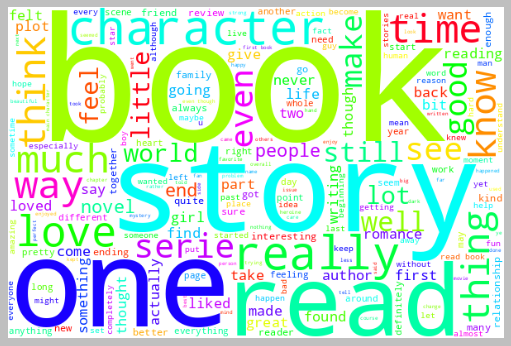

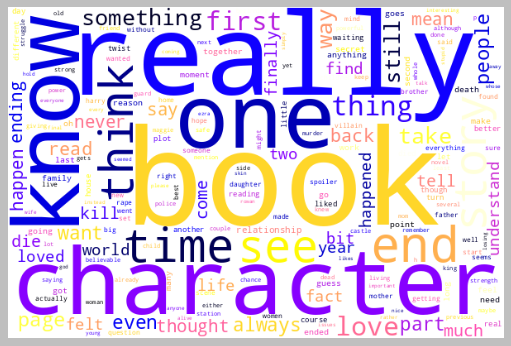

In [117]:
visualize(0, df_s.sample(10000), style = 'gist_rainbow_r')
visualize(1, df_s.sample(10000), style = 'gnuplot2')


### 3. Prediction

In [133]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import SGDClassifier, LogisticRegression

from sklearn.metrics import classification_report, confusion_matrix

In [134]:
X_train, X_test, y_train, y_test = train_test_split(df_s['sentence'], df_s['spoiler'], test_size=0.25, random_state=42)

In [135]:
cv = CountVectorizer()

In [136]:
X_tr_train = cv.fit_transform(X_train)
X_tr_test = cv.transform(X_test)

In [137]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_tr_train, y_train)
predicted = clf.predict(X_tr_test)

print(classification_report(y_test.tolist(), predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      0.98      0.98   3172009
           1       0.19      0.15      0.17    106531

    accuracy                           0.95   3278540
   macro avg       0.58      0.56      0.57   3278540
weighted avg       0.95      0.95      0.95   3278540

[[3106310   65699]
 [  91005   15526]]


In [138]:
clf = LogisticRegression(random_state=0).fit(X_tr_train, y_train)
predicted = clf.predict(X_tr_test)

print(classification_report(y_test.tolist(), predicted))
print(confusion_matrix(y_test, predicted))

/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.97      1.00      0.98   3172009
           1       0.40      0.02      0.04    106531

    accuracy                           0.97   3278540
   macro avg       0.68      0.51      0.51   3278540
weighted avg       0.95      0.97      0.95   3278540

[[3168842    3167]
 [ 104431    2100]]


In [139]:
clf = SGDClassifier(alpha=0.1, random_state=42).fit(X_tr_train, y_train)
predicted = clf.predict(X_tr_test)

print(classification_report(y_test.tolist(), predicted))
print(confusion_matrix(y_test, predicted))

/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98   3172009
           1       0.00      0.00      0.00    106531

    accuracy                           0.97   3278540
   macro avg       0.48      0.50      0.49   3278540
weighted avg       0.94      0.97      0.95   3278540

[[3172009       0]
 [ 106531       0]]


In [140]:
tv = TfidfVectorizer(max_df=500, min_df=10)

In [141]:
X_tv_train = tv.fit_transform(X_train)
X_tv_test = tv.transform(X_test)

In [142]:
clf = MultinomialNB(alpha=0.1)
clf.fit(X_tv_train, y_train)
predicted = clf.predict(X_tv_test)

print(classification_report(y_test.tolist(), predicted))
print(confusion_matrix(y_test, predicted))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98   3172009
           1       0.49      0.00      0.00    106531

    accuracy                           0.97   3278540
   macro avg       0.73      0.50      0.49   3278540
weighted avg       0.95      0.97      0.95   3278540

[[3171814     195]
 [ 106342     189]]


In [143]:
clf = LogisticRegression(random_state=0).fit(X_tv_train, y_train)
predicted = clf.predict(X_tv_test)

print(classification_report(y_test.tolist(), predicted))
print(confusion_matrix(y_test, predicted))

/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.97      1.00      0.98   3172009
           1       0.46      0.00      0.00    106531

    accuracy                           0.97   3278540
   macro avg       0.72      0.50      0.49   3278540
weighted avg       0.95      0.97      0.95   3278540

[[3171828     181]
 [ 106375     156]]


In [144]:
clf = SGDClassifier(alpha=0.1, random_state=42).fit(X_tv_train, y_train)
predicted = clf.predict(X_tv_test)

print(classification_report(y_test.tolist(), predicted))
print(confusion_matrix(y_test, predicted))

/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/walltime/Venvs/sklearn-env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

              precision    recall  f1-score   support

           0       0.97      1.00      0.98   3172009
           1       0.00      0.00      0.00    106531

    accuracy                           0.97   3278540
   macro avg       0.48      0.50      0.49   3278540
weighted avg       0.94      0.97      0.95   3278540

[[3172009       0]
 [ 106531       0]]
